In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from imblearn.over_sampling import SMOTE

In [17]:
# Cargar datos
datos = pd.read_csv('database.csv')
print("Valores nulos por columna:")
print(datos.isnull().sum())

Valores nulos por columna:
Date                              0
Time                              0
Latitude                          0
Longitude                         0
Type                              0
Depth                             0
Depth Error                   18951
Depth Seismic Stations        16315
Magnitude                         0
Magnitude Type                    3
Magnitude Error               23085
Magnitude Seismic Stations    20848
Azimuthal Gap                 16113
Horizontal Distance           21808
Horizontal Error              22256
Root Mean Square               6060
ID                                0
Source                            0
Location Source                   0
Magnitude Source                  0
Status                            0
dtype: int64


In [18]:
# Consideramos el dataset solo con estas columnas
columnas = ['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Magnitude', 'Magnitude Type', 'ID', 'Source']

datos_clean = datos[columnas].copy()

# Limpia los datos nulos en "Magnitude Type" (3)
datos_clean = datos_clean.dropna(subset=['Magnitude Type'])

# Convertimos "Date" a datetime
datos_clean['Date'] = pd.to_datetime(datos_clean['Date'], format='%m/%d/%Y', errors='coerce') #*
datos_clean['Year'] = datos_clean['Date'].dt.year
datos_clean['Month'] = datos_clean['Date'].dt.month


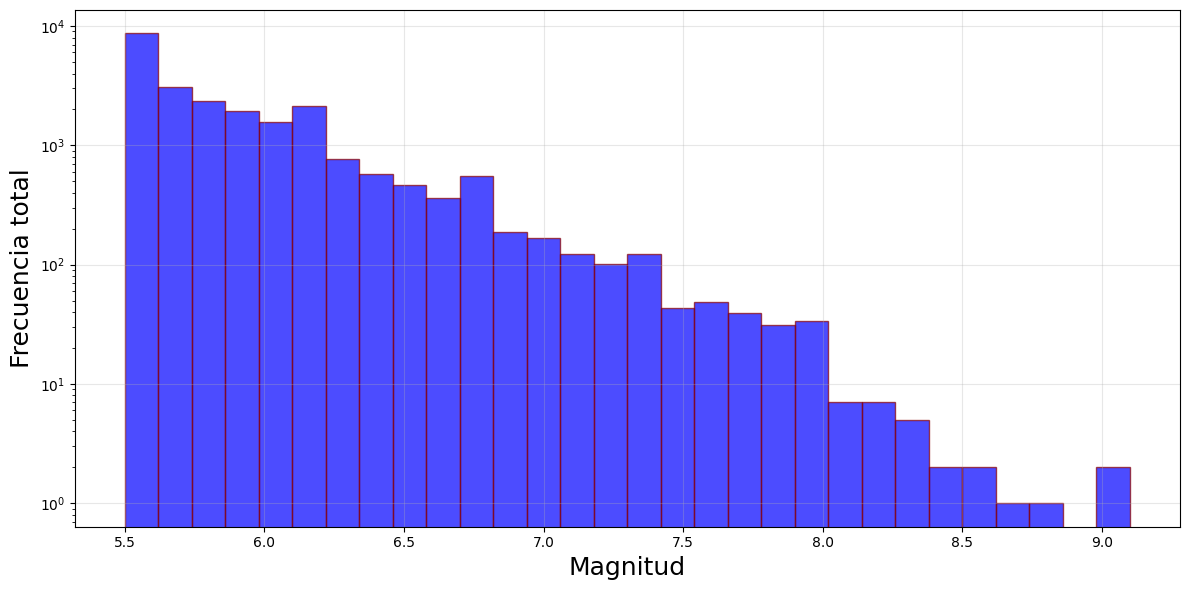

In [19]:
# Gráfico 1: frecuencias terremotos
plt.figure(figsize=(12,6))
plt.hist(datos_clean['Magnitude'], bins=30, color='blue', edgecolor='darkred', alpha=0.7)
plt.xlabel('Magnitud', fontsize=18)
plt.ylabel('Frecuencia total', fontsize=18)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("frecuencia_terremotos_magnitud.png", dpi=300)
plt.show()

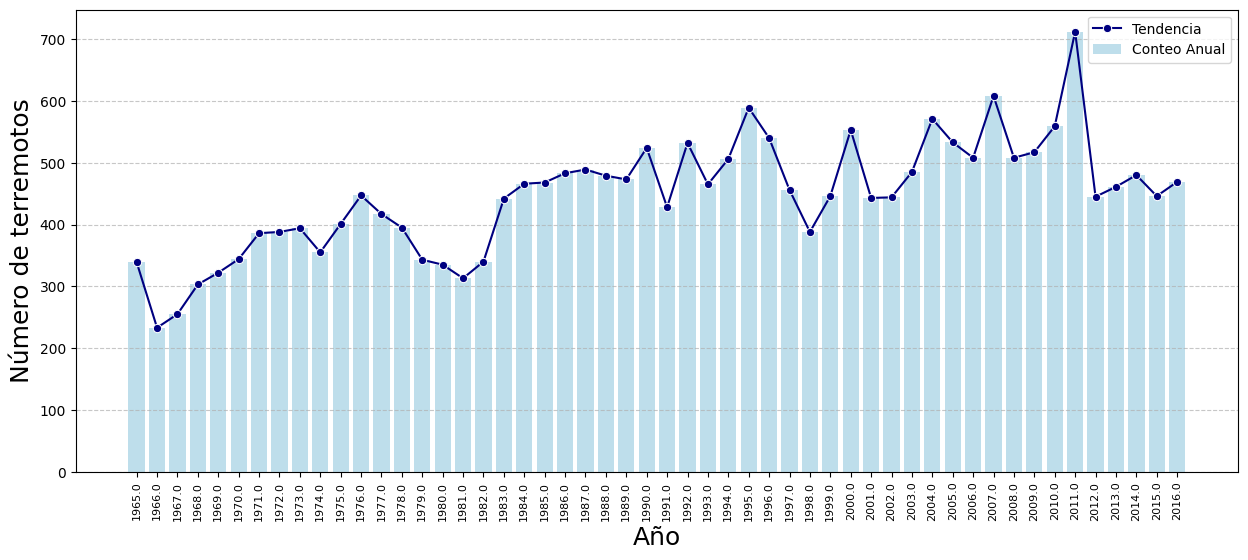

In [20]:
# Gráfico 1.2: terremotos por año

terremotos_por_año = datos_clean[datos_clean['Type'] == 'Earthquake']['Year'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=terremotos_por_año.index, y=terremotos_por_año.values, color='skyblue', alpha=0.6, label='Conteo Anual')
sns.lineplot(x=np.arange(len(terremotos_por_año)), y=terremotos_por_año.values, color='navy', marker='o', label='Tendencia')


plt.xlabel('Año', fontsize=18)
plt.ylabel('Número de terremotos', fontsize=18)
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("terremotos_por_año.png", dpi=300)
plt.show()


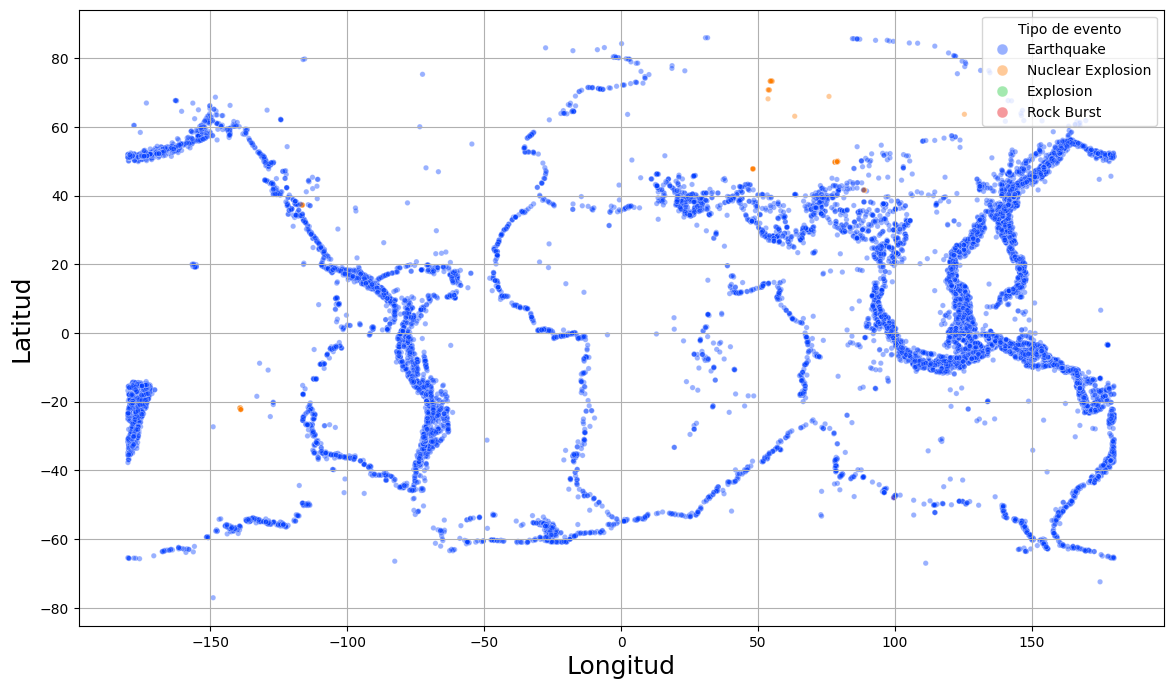

In [21]:
# Gráfico 2: mapa de eventos (geográfico)
plt.figure(figsize=(14, 8))
sns.scatterplot(data=datos_clean, x='Longitude', y='Latitude', hue='Type', s=15, alpha=0.4, palette='bright')
plt.xlabel('Longitud', fontsize=18)
plt.ylabel('Latitud', fontsize=18)
plt.legend(loc='upper right', title='Tipo de evento', markerscale=2)
plt.grid(True)
plt.savefig("mapa_terremotos.png", dpi=300)
plt.show()

Type
Earthquake           23229
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: count, dtype: int64


/tmp/ipython-input-2899977588.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frec_type.index, y=frec_type.values, palette="viridis")


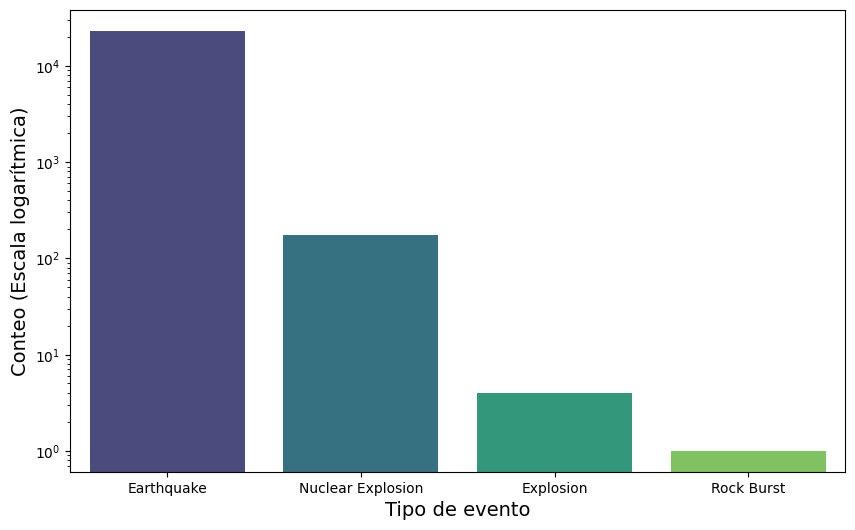

In [22]:
# Gráfico 3: tipos
frec_type = datos_clean['Type'].value_counts()
print(frec_type)

plt.figure(figsize=(10, 6))
sns.barplot(x=frec_type.index, y=frec_type.values, palette="viridis")
plt.ylabel('Conteo (Escala logarítmica)', fontsize=14)
plt.xlabel('Tipo de evento', fontsize=14)

# Usamos escala logarítmica
plt.yscale('log')
plt.savefig("distribucion_clases.png", dpi=300)
plt.show()

Como las clases son extremadamente imbalanceadas se trabajará de forma binaria ("Earthquake" y "No-Earthquake") y se aplicará SMOTE para balancear

In [23]:
datos_clean["non_earthquake"] = (datos_clean["Type"] != "Earthquake").astype(int)
print("Distribución del dataset binario:")
print(datos_clean["non_earthquake"].value_counts()) # 0: Earthquake, 1: No-Earthquake

features = ['Latitude', 'Longitude', 'Depth', 'Magnitude']
X = datos_clean[features]
y = datos_clean["non_earthquake"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=70, stratify=y)

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)

print("Antes de SMOTE (Training set):", y_train1.value_counts())

smote = SMOTE(random_state=70, k_neighbors=3)
X_train_balanced1, y_train_balanced1 = smote.fit_resample(X_train_scaled1, y_train1)

print("Después de SMOTE (Training set):", y_train_balanced1.value_counts())

Distribución del dataset binario:
non_earthquake
0    23229
1      180
Name: count, dtype: int64
Antes de SMOTE (Training set): non_earthquake
0    16260
1      126
Name: count, dtype: int64
Después de SMOTE (Training set): non_earthquake
0    16260
1    16260
Name: count, dtype: int64


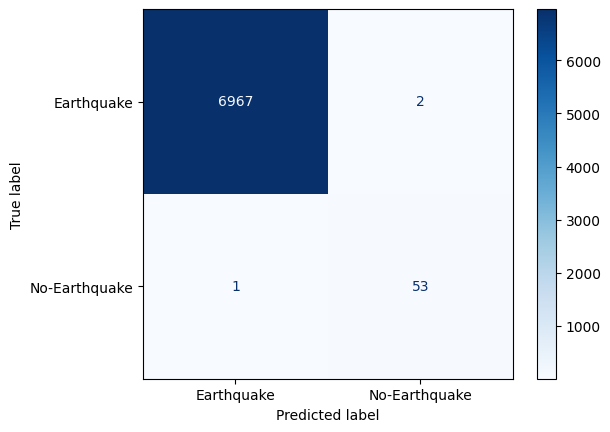

In [24]:
# CM con Random Forest
model = RandomForestClassifier(n_estimators=300, max_depth=None, class_weight=None, random_state=70)
model.fit(X_train_balanced1, y_train_balanced1)

y_pred1 = model.predict(X_test_scaled1)

cm1 = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(cm1, display_labels=["Earthquake", "No-Earthquake"])

disp.plot(cmap='Blues')
plt.savefig("cm_RF.png", dpi=400)
plt.show()

In [25]:
print("\n--- Classification Report ---")
print(classification_report(y_test1, y_pred1, target_names=["Earthquake", "No-Earthquake"]))


--- Classification Report ---
               precision    recall  f1-score   support

   Earthquake       1.00      1.00      1.00      6969
No-Earthquake       0.96      0.98      0.97        54

     accuracy                           1.00      7023
    macro avg       0.98      0.99      0.99      7023
 weighted avg       1.00      1.00      1.00      7023



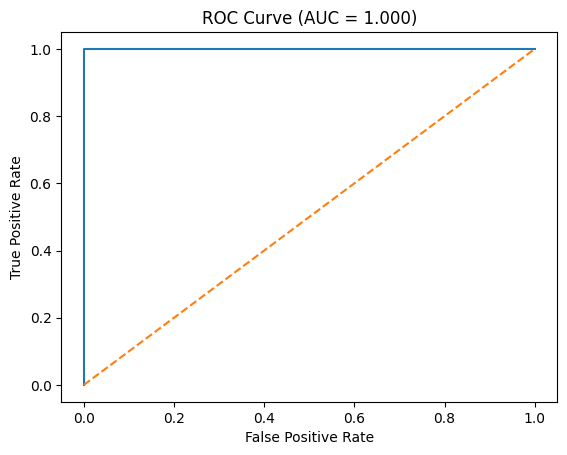

In [26]:
# Curva ROC
y_prob1 = model.predict_proba(X_test_scaled1)[:,1]

fpr, tpr, thresholds = roc_curve(y_test1, y_prob1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("curva_ROC.png", dpi=300)
plt.show()


In [27]:
# Hiperparámetros
rf = RandomForestClassifier(random_state=70)

param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, verbose=2, random_state=70, n_jobs=4)
rf_random_search.fit(X_train_balanced1, y_train_balanced1)
best_rf = rf_random_search.best_estimator_

print("Mejores hiperparámetros")
print(rf_random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


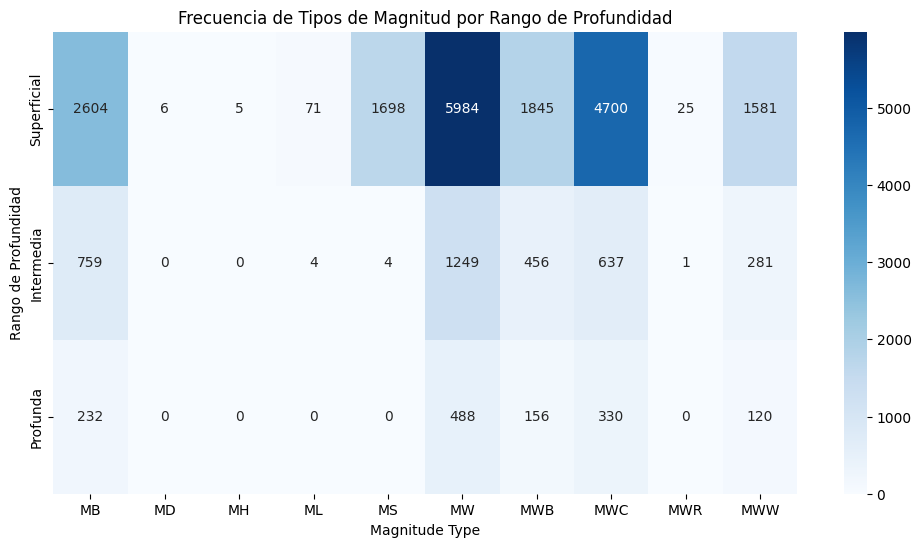

In [28]:
# Crear rangos de profundidad
datos_clean["Depth_bin"] = pd.cut(datos_clean["Depth"], bins=[0, 70, 300, 700],
                               labels=["Superficial", "Intermedia", "Profunda"])

# Tabla de frecuencia
tabla = pd.crosstab(datos_clean["Depth_bin"], datos_clean["Magnitude Type"])

plt.figure(figsize=(12,6))
sns.heatmap(tabla, annot=True, fmt='d', cmap='Blues')

plt.title("Frecuencia de Tipos de Magnitud por Rango de Profundidad")
plt.ylabel("Rango de Profundidad")
plt.xlabel("Magnitude Type")
plt.savefig("heatmap_magnitud.png", dpi=300)
plt.show()


Generando curva de aprendizaje (versión limpia)...


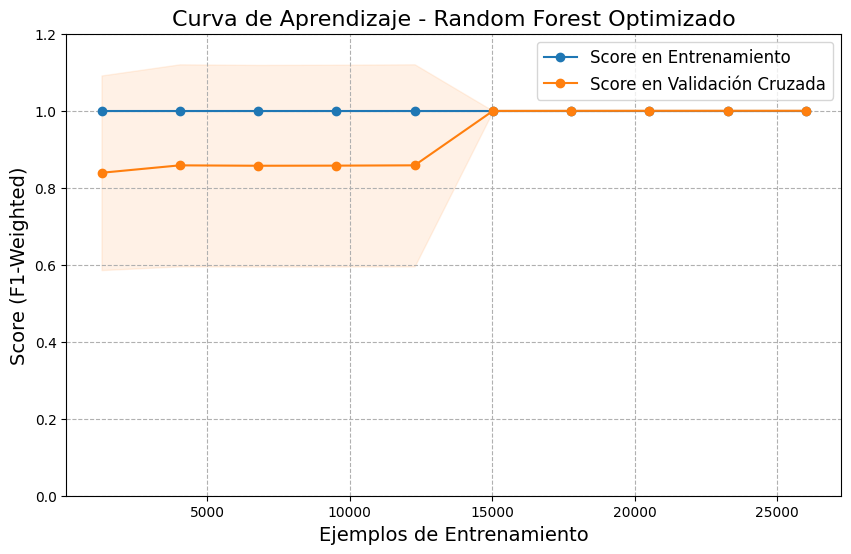

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve_clean(estimator, title, X, y, cv=5, n_jobs=-1):
    """
    Genera un gráfico de la curva de aprendizaje con formato optimizado.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=16)

    plt.ylim(0.0, 1.2)

    plt.xlabel("Ejemplos de Entrenamiento", fontsize=14)
    plt.ylabel("Score (F1-Weighted)", fontsize=14)

    train_sizes = np.linspace(0.05, 1.0, 10)

    # Calcular la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')

    # Calcular promedios y desviación estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(linestyle='--')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#1f77b4")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#ff7f0e")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="#1f77b4", label="Score en Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#ff7f0e", label="Score en Validación Cruzada")

    plt.legend(loc="best", fontsize=12)
    plt.show()

print("Generando curva de aprendizaje (versión limpia)...")

plot_learning_curve_clean(
    best_rf,
    "Curva de Aprendizaje - Random Forest Optimizado",
    X_train_balanced1,
    y_train_balanced1,
    cv=5,
    n_jobs=-1
)


--- Gráfico Final: Importancia de las Features ---
Cantidad de nombres: 4
Cantidad de valores de importancia: 4
     Feature  Importancia
2      Depth     0.614102
0   Latitude     0.231782
1  Longitude     0.149949
3  Magnitude     0.004166


/tmp/ipython-input-50768876.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=df_importancia, palette='viridis')


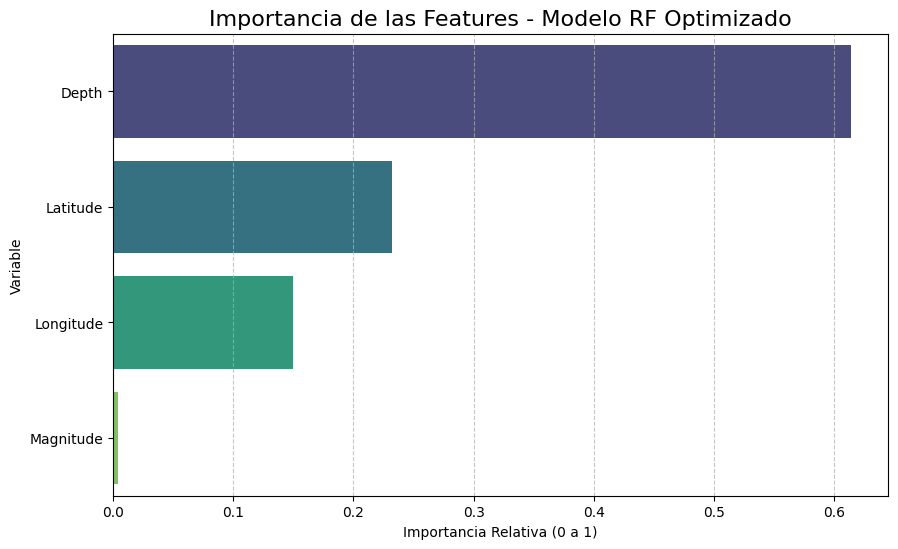

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Gráfico Final: Importancia de las Features ---")

features_num = ['Latitude', 'Longitude', 'Depth', 'Magnitude']

importancias = best_rf.feature_importances_

print(f"Cantidad de nombres: {len(features_num)}")
print(f"Cantidad de valores de importancia: {len(importancias)}")

df_importancia = pd.DataFrame({
    'Feature': features_num,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print(df_importancia)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=df_importancia, palette='viridis')
plt.title('Importancia de las Features - Modelo RF Optimizado', fontsize=16)
plt.xlabel('Importancia Relativa (0 a 1)')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()